# [Module 0.0] 데이터 탐색 (Exploratory Data Analysis)


Kaggle 에서 Store Item Demand 데이타를 가져와서 데이타 탐색을 하여, 데이타의 내용을 파악 합니다.<br>
이 노트북은 아래와 같은 과정을 확인 합니다.

- 데이타 요약 
- 기본 통계 확인
- 개별 아이템의 Sales 시계열 확인
- Seasonality and Trend 확인


---
Reference:
- Data Source: Store Item Demand Forecasting Challenge,  
    - https://www.kaggle.com/c/demand-forecasting-kernels-only/overview
    

- EDA + Prophet + Winning Solution 3.0
    - 여기서 일부 EDA 소스 코드를 가져옴
    - https://www.kaggle.com/myster/eda-prophet-winning-solution-3-0


In [1]:
import pandas as pd
import numpy as np
import itertools
import os

#Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
np.random.seed(786)

## Data Shape (데이터 요약)

데이터가 date, store, item, sales의 4개의 컬럼으로 구성 됨


- date: 
    - yyyy-mm-dd 형태로 timestamp 컬럼 임. 2013.0.01 ~ 2017.12.31 일까지의 일별 데이타로 5년 데이터를 가지고 있음
- store: 
    - 10개의 상점으로 구성되어 있고, 1 ~ 10 까지의 값을 가지고 있음
- item: 
    - 50개의 이이템을 가지고 있으면, 1~50 까지의 값을 가지고 있음
- sales: 
    - 특정 store, 특정 item에 대한 판매 갯수 임.


In [2]:
data_dir = 'data'
data_file_name = 'train.csv'

In [3]:
data_type = {'store':'int8', 'item': 'int8', 'sales': 'int16'}
df = pd.read_csv(os.path.join(data_dir,data_file_name), parse_dates=['date'], dtype= data_type)
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
df.info() # 913,000 rows

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int8          
 2   item    913000 non-null  int8          
 3   sales   913000 non-null  int16         
dtypes: datetime64[ns](1), int16(1), int8(2)
memory usage: 10.4 MB


데이터의 시작값과 마지막 값을 확인

In [5]:
print(df.date.min()) 
print(df.date.max())

2013-01-01 00:00:00
2017-12-31 00:00:00


5년 동안의 유니크한 날짜 1826, 유니크한 상점 10, 유니크한 아이템 50 를 곱해보면 913,000 임. 미싱 데이터가 없을음 확인 함

In [6]:
n_total = df.sales.count()
n_item = df.item.nunique()
n_store = df.store.nunique()
n_date = df.date.nunique()
assert (n_total == n_date * n_item * n_store)
print("total rows: {}, unique date: {}, uniuqe item: {}, unique store: {},\nunique date * unique item * unique store: {}".format(
    n_total, n_date, n_item, n_store, n_date * n_item * n_store))

total rows: 913000, unique date: 1826, uniuqe item: 50, unique store: 10,
unique date * unique item * unique store: 913000


## 기본 통계 (Stat)

판매 갯수가 0 ~ 231개 사이이고, 중간값이 47개, 평균값이 약 52 임.<br>

In [7]:
# 판매 갯수
df['sales'].describe()

count    913000.000000
mean         52.250287
std          28.801144
min           0.000000
25%          30.000000
50%          47.000000
75%          70.000000
max         231.000000
Name: sales, dtype: float64

분포는 왼쪽으로 치우쳐져 있음. 일반적인 Retail에서의 분포임. 적게 팔리는 판매 갯수가 많은 비율을 가지고 있고, 많이 팔린 판매 갯수는 적은 비율 임

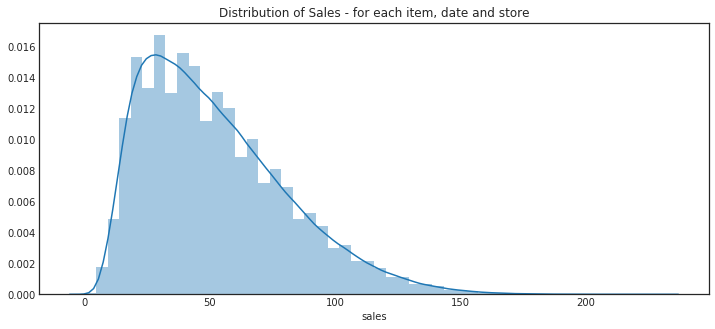

In [8]:
plt.figure(figsize = (12,5))
plt.title("Distribution of Sales - for each item, date and store")
ax = sns.distplot(df['sales'])

## Individual Item's Sale Trend

특정 상점, 특정 아이템에 대한 5년의 Sales를 시계열을 확인 합니다.<br>
여기서는 상점1, 상점2, 아이템1, 아이템2의 Sales를 일별 데이터를 주별('W')로 합산하여  확인 하였습니다.
4개의 시계열이 비슷한 패턴을 보이는 것을 확인할 수 있습니다.

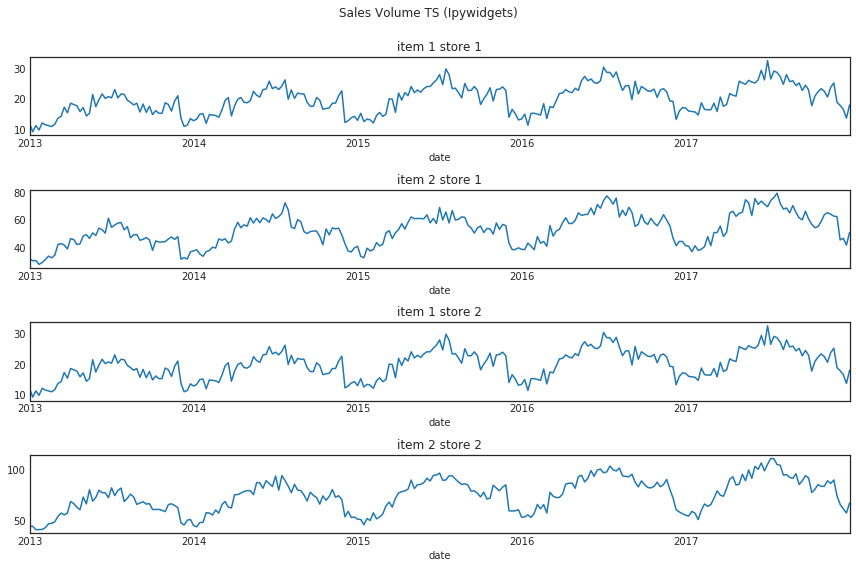

In [9]:
def update_ts_simple(s1_num=1, s2_num=2, i1_num=1, i2_num=2):
    fig, ax = plt.subplots(4, figsize = (12, 8))
    df.query('store == @s1_num & item == @i1_num').set_index('date')['sales'].resample('W').mean().plot(ax = ax[0])
    df.query('store == @s1_num & item == @i2_num').set_index('date')['sales'].resample('W').mean().plot(ax = ax[1])
    df.query('store == @s1_num & item == @i1_num').set_index('date')['sales'].resample('W').mean().plot(ax = ax[2])
    df.query('store == @s2_num & item == @i2_num').set_index('date')['sales'].resample('W').mean().plot(ax = ax[3])

    ax[0].set_title('item {} store {}'.format(i1_num, s1_num))
    ax[1].set_title('item {} store {}'.format(i2_num, s1_num))
    ax[2].set_title('item {} store {}'.format(i1_num, s2_num))
    ax[3].set_title('item {} store {}'.format(i2_num, s2_num))
    fig.suptitle('Sales Volume TS (Ipywidgets)')
    fig.tight_layout(rect=[0, 0, 1, 0.94])
    fig.canvas.draw()
    fig.show()
    
s1_num = 1 # 상점 1
s2_num = 2 # 상점 2
i1_num = 1 # 아이템 1
i2_num = 2 # 아이템 2  
update_ts_simple(s1_num, s2_num, i1_num, i2_num)    

## Seasonality and Trend 파악

date 컬럼을 통해서 아래의 컬럼들을 추가 합니다.

- Year: 해당 년도
- Month: 해당 월
- Day: 해달 일
- Dayofweek: 일주일의 요일의 나타냄 (0: Mon, 1: Tue, 2: Wed, 3: Thu, 4: Fri, 5: Sat, 6: Sun)
- Dayofyear: 1년 중의 몇 일인지를 나타냄 (1/1 --> 1일, 12/31 --> 365일)
- Weekofyear: 1년 중의 몇 주인지를 나타냄 (2013.1.1 --> 1주, 2013.12.29 --> 52주)

In [10]:
import re

def add_datepart (df, fldname, inplace=False, drop=False):
    if not inplace: df = df.copy()        
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64
    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear','Weekofyear']
    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    if drop: 
        df.drop(fldname, axis=1, inplace=True)
    if not inplace: return df 

df_trainext = add_datepart(df, 'date', inplace=False)
display(df_trainext.head(365))

,date,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Weekofyear
0,2013-01-01,1,1,13,2013,1,1,1,1,1,1
1,2013-01-02,1,1,11,2013,1,1,2,2,2,1
2,2013-01-03,1,1,14,2013,1,1,3,3,3,1
3,2013-01-04,1,1,13,2013,1,1,4,4,4,1
4,2013-01-05,1,1,10,2013,1,1,5,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...
360,2013-12-27,1,1,18,2013,12,52,27,4,361,52
361,2013-12-28,1,1,17,2013,12,52,28,5,362,52
362,2013-12-29,1,1,14,2013,12,52,29,6,363,52
363,2013-12-30,1,1,5,2013,12,1,30,0,364,1


### 일별 총 Sales 추이

아래는 일별로 10개의 상점, 50개의 아이템의 Sales를 모두 합산하여 시계열을 보여줌.<br>
총 1826 (356 * 5 + 1[윤달]) 일의 Sales 합산을 보여 줌.<br>
거시적으로 년도별 Seansonality 가 보이고, 년도별로 증가 추세의 Trend가 보임


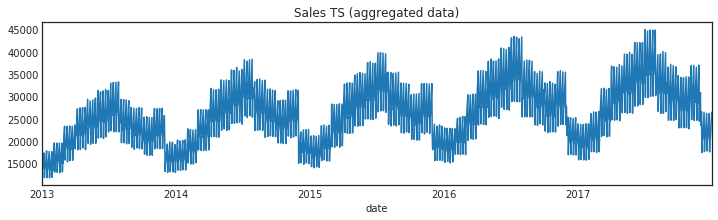

In [11]:
df_trainext.groupby('date').sum()['sales'].plot(
    figsize=(12,3), 
    title='Sales TS (aggregated data)')

### Yearly, Monthly, Weekly Seasonality 파악

Seasonality 를 년, 월, 주 에 대해서 있는지를 확인 하는 과정 입니다.

**Seasonality 기준**

- Yearly Seasonality
    - 교차(year, month) 
    - 값: Sales의 합산
- Monthly Seasonality
    - 교차(month, day) 
    - 값: Sales의 합산
- Weekly Seasonality by year
    - 교차(year, Dayofweek) 
    - 값: Sales의 합산
- Weekly Seasonality by month
    - 교차(month, Dayofweek) 
    - 값: Sales의 합산
    
**아래 차트 해석**
- Yearly Seasonality
    - 매우 명확하게 Seasonality를 보여 주고 있음. 예를 들어 매해 7월에 가장 높은 Sales를 기록하고 있고, 1월에 가장 낮은 Sales를 
기혹하고 있음.
- Weekly Seasonality by month 
    - 매우 명확하게 월 대비 Weekly Seasonality 가 나타남. 예를 들어 거의 모든 월이 일요일(6)에 가장 높은 Sales를 기록하고, 월요일(0)에 가장 낮은 Sales를 기록 함.
- Weekly Seasonality by year
    - 매우 명확하게 월 대비 Yearly Seasonality 가 나타남. 예를 들어 거의 모든 해에 일요일(6)에 가장 높은 Sales를 기록하고, 월요일(0)에 가장 낮은 Sales를 기록 함.
- Monthly Seasonality
    - Monthly Seasonality 가 일별로 명확하지 않음. 하지만 Weekly Seasonality가 영향을 받아 주기적인 패턴을 보여주고 있음.

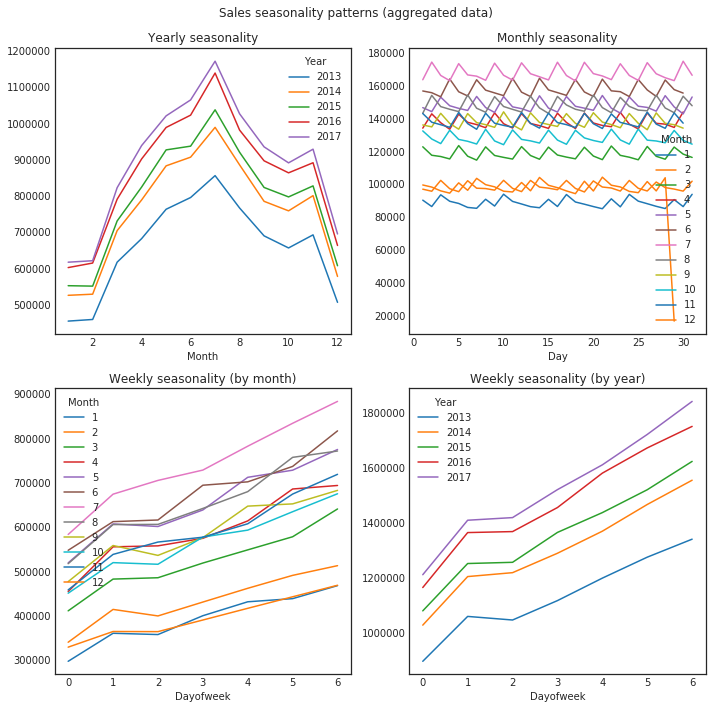

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Month', aggfunc='sum').plot(title="Yearly seasonality", ax=ax[0,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Day', aggfunc='sum').plot(title="Monthly seasonality", ax=ax[0,1])
_ = pd.pivot_table(df_trainext, values='sales', columns='Month', index='Dayofweek', aggfunc='sum').plot(title="Weekly seasonality (by month)", ax=ax[1,0])
_ = pd.pivot_table(df_trainext, values='sales', columns='Year', index='Dayofweek', aggfunc='sum').plot(title="Weekly seasonality (by year)", ax=ax[1,1])
fig.suptitle('Sales seasonality patterns (aggregated data)')
fig.tight_layout(rect=[0, 0, 1, 0.96])

## Annual Trend

아래 차트를 보면 해마다 증가하는 추세를 확인할 수 있음

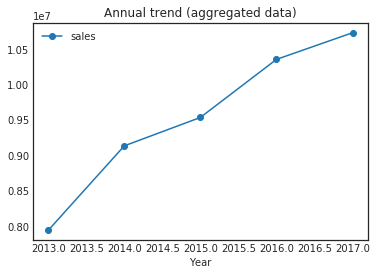

In [13]:
_ = pd.pivot_table(df_trainext, values='sales', index='Year', aggfunc='sum').plot(style='-o', title="Annual trend (aggregated data)")